### Edgar Moises Hernandez-Gonzalez
#### 30/04/20-19/11/20
#### Clasificacion de calculo mental en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFT (3D)
##### Resize proporcional de (45 x n_canales) x 27 [1440x27]
##### Validacion cruzada de 5

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
# todos los canales
x = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/MeCa_car_15_3.csv", header=None)

# etiquetas
y = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/EtiquetasMeCa15RMFH-03.csv", header=None).values

In [6]:
print(x.shape)
print(y.shape)

(304, 43008)
(304, 1)


In [7]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 304


In [8]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [12]:
# unir 32 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical(data):
  fs = 512
  datos = np.zeros((data.shape[0],1440,27))
  temporal = np.zeros((1440,27))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #n canales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      #sig = sig[160:1184]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=512, window='hann', nperseg=512,
                              noverlap=480, nfft=1024, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
      #temporal[j*45:(j+1)*45, :] = np.log(Sxx[16:61, :])
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
# llamar a unir_espectrogramas_vertical
inicio = time.time()

x = unir_espectrogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
Tiempo: 9.481671333312988


In [17]:
print(x.shape)

(304, 1440, 27)


In [18]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

5.374782701821332
-18.076693323399383
-1.3278533152028704


In [ ]:
# convertir a float
x = x.astype('float32')

# escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [ ]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.8957971
-3.012782
-0.22130905


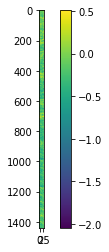

In [ ]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.show()

In [ ]:
# convertir de 3D a 4D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

print(x.shape)

(304, 1440, 27, 1)


In [ ]:
# mc = ModelCheckpoint('/content/drive/My Drive/MentalCalculation/Modelos/Model_STFT_15_3_CV.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
skf = StratifiedKFold(n_splits = 5)

In [ ]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(2, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(2, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.46350470185279846
accuracy:  0.9016393423080444
f1: 0.8933566433566433
confusion matrix:
 [[19  3]
 [ 3 36]]
AUC 0.9452214452214451


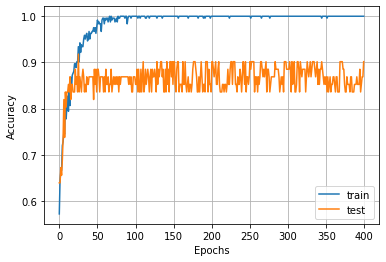

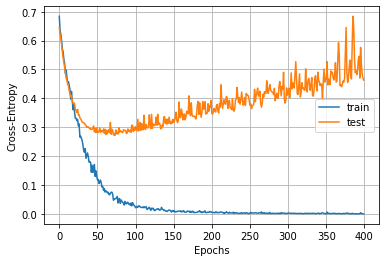


Iteration: 2
loss:  0.9331521391868591
accuracy:  0.8360655903816223
f1: 0.8282657657657657
confusion matrix:
 [[19  3]
 [ 7 32]]
AUC 0.9207459207459207


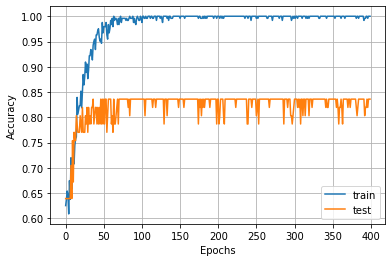

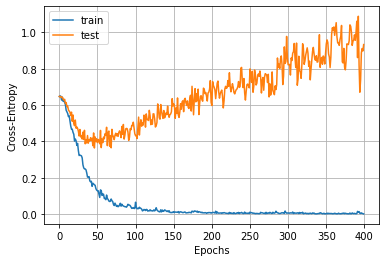


Iteration: 3
loss:  0.748639702796936
accuracy:  0.868852436542511
f1: 0.8471177944862156
confusion matrix:
 [[15  7]
 [ 1 38]]
AUC 0.8904428904428905


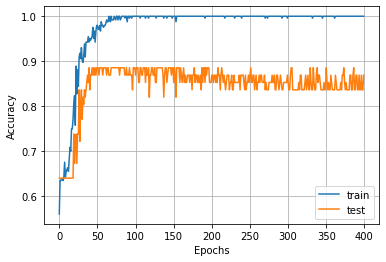

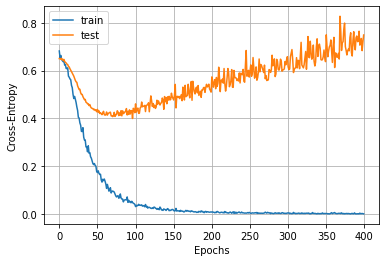


Iteration: 4
loss:  0.8742617964744568
accuracy:  0.8852459192276001
f1: 0.8680877355576151
confusion matrix:
 [[16  7]
 [ 0 38]]
AUC 0.9124713958810069


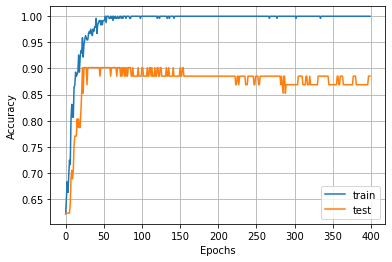

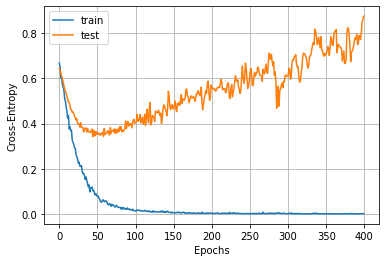


Iteration: 5
loss:  1.0202951431274414
accuracy:  0.7666666507720947
f1: 0.7222222222222222
confusion matrix:
 [[11 11]
 [ 3 35]]
AUC 0.888755980861244


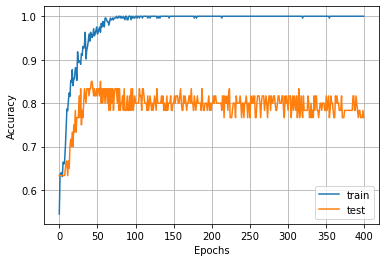

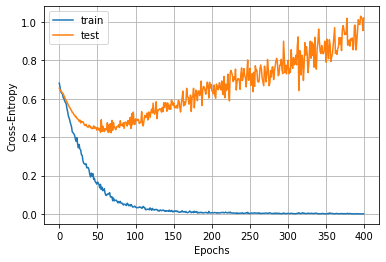


Resultados:
loss: [0.46350470185279846, 0.9331521391868591, 0.748639702796936, 0.8742617964744568, 1.0202951431274414]
accuracy: [0.9016393423080444, 0.8360655903816223, 0.868852436542511, 0.8852459192276001, 0.7666666507720947]
f1: [0.8933566433566433, 0.8282657657657657, 0.8471177944862156, 0.8680877355576151, 0.7222222222222222]
auc: [0.9452214452214451, 0.9207459207459207, 0.8904428904428905, 0.9124713958810069, 0.888755980861244]
Tiempo: 139.16466784477234


In [ ]:
inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D()
  
  history = model.fit(x_train, y_train, epochs=400, batch_size=20,
                      validation_data=(x_test, y_test), verbose=0)
                      #, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  #fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1440, 27, 2)       20        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 720, 13, 2)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 720, 13, 2)        38        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 360, 6, 2)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4320)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                138272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean F1: %.4f" % np.mean(array_f1))
print("std: (+/- %.4f)" % np.std(array_f1))
print("Mean auc: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max F1: %.4f" % np.max(array_f1))
print("Max auc: %.4f" % np.max(array_auc))

Mean Accuracy: 0.8517
std: (+/- 0.0477)
Mean F1: 0.8318
std: (+/- 0.0589)
Mean auc: 0.9115
std: (+/- 0.0209)
Max Accuracy: 0.9016
Max F1: 0.8934
Max auc: 0.9452


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Nov 11 05:26:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    43W /  70W |    755MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Con Data Augmentation
'''inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]
  y_train_categorical, y_test_categorical = y_categorical[iTrain], y_categorical[jTest]

  n_samples_train = len(y_train)

  model = CNN_2D()
  
  history = model.fit_generator(datagen.flow(x_train, y_train_categorical, batch_size=20),
                                steps_per_epoch=np.ceil(n_samples_train/20),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0) #callbacks=[mc])
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)'''

'inicio = time.time()\narray_loss = []\narray_acc = []\narray_f1 = []\narray_auc = []\ni = 0\nfor iTrain, jTest in skf.split(x, y):\n  print("\nIteration:", i + 1)\n  x_train, x_test = x[iTrain], x[jTest]\n  y_train, y_test = y[iTrain], y[jTest]\n  y_train_categorical, y_test_categorical = y_categorical[iTrain], y_categorical[jTest]\n\n  n_samples_train = len(y_train)\n\n  model = CNN_2D()\n  \n  history = model.fit_generator(datagen.flow(x_train, y_train_categorical, batch_size=20),\n                                steps_per_epoch=np.ceil(n_samples_train/20),\n                                epochs=400,\n                                validation_data=(x_test, y_test_categorical),\n                                verbose=0) #callbacks=[mc])\n  \n  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)\n  array_loss.append(test_loss)\n  print("loss: ", test_loss)\n  array_acc.append(test_acc)\n  print("accuracy: ", test_acc)\n    \n  probabilidades = model.predict(